# Installing Packages

In [0]:
!pip install --no-cache-dir torch-tensornet==0.0.7 torchsummary==1.5.1

# Imports
Importing necessary packages and modules

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

from torchsummary import summary
from tensornet import train, evaluate
from tensornet.data import CIFAR10
from tensornet.model import ResNet18
from tensornet.model.utils import LRFinder
from tensornet.model.utils.loss import cross_entropy_loss
from tensornet.model.utils.optimizers import sgd
from tensornet.model.utils.callbacks import reduce_lr_on_plateau
from tensornet.gradcam import GradCAMView
from tensornet.utils import initialize_cuda, plot_metric, class_level_accuracy

# Configuration

Set various parameters and hyperparameters

In [0]:
class Args:

    # Data Loading
    # ============

    train_batch_size = 64
    val_batch_size = 64
    num_workers = 4

    # Augmentation
    # ============
    horizontal_flip_prob = 0.2
    rotate_degree = 20
    cutout = 0.3

    # Training
    # ========
    random_seed = 1
    epochs = 50
    momentum = 0.9
    start_lr = 1e-7
    end_lr = 5
    num_iter = 400
    min_lr = 1e-4
    lr_decay_factor = 0.1
    lr_decay_patience = 2

    # Evaluation
    # ==========
    sample_count = 25

## Set Seed and Get GPU Availability

In [3]:
# Initialize CUDA and set random seed
cuda, device = initialize_cuda(Args.random_seed)

GPU Available? True


## Download Dataset

Importing the CIFAR-10 class to download dataset and create data loader

In [4]:
dataset = CIFAR10(
    train_batch_size=Args.train_batch_size,
    val_batch_size=Args.val_batch_size,
    cuda=cuda,
    num_workers=Args.num_workers,
    horizontal_flip_prob=Args.horizontal_flip_prob,
    rotate_degree=Args.rotate_degree,
    cutout=Args.cutout
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Training and Validation Dataloaders
This is the final step in data preparation. It sets the dataloader arguments and then creates the dataloader

In [0]:
# Create train data loader
train_loader = dataset.loader(train=True)

# Create val data loader
val_loader = dataset.loader(train=False)

# Model Architecture and Summary

In [6]:
model = ResNet18().to(device)  # Create model
summary(model, dataset.image_size)  # Display model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# Find Initial Learning Rate

In [7]:
model = ResNet18().to(device)  # Create model
optimizer = sgd(model, Args.start_lr, Args.momentum)  # Create optimizer
criterion = cross_entropy_loss()  # Create loss function

# Find learning rate
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=Args.end_lr, num_iter=Args.num_iter, step_mode='exp')


Learning rate search finished.


Learning Rate: 0.012059247341566626
Loss: 1.8264832157316113


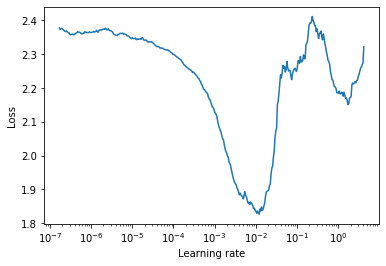

In [8]:
# Get best initial learning rate
initial_lr = lr_finder.best_lr

# Print learning rate and loss
print('Learning Rate:', initial_lr)
print('Loss:', lr_finder.best_loss)

# Plot learning rate vs loss
lr_finder.plot()

# Reset graph
lr_finder.reset()

# Model Training and Validation

In [9]:
train_accuracies = []
val_losses = []
val_accuracies = []
incorrect_samples = []

criterion = cross_entropy_loss()  # Create loss function
optimizer = sgd(model, initial_lr, Args.momentum)  # Create optimizer
scheduler = reduce_lr_on_plateau(  # Define Reduce LR on plateau
    optimizer, factor=Args.lr_decay_factor,
    patience=Args.lr_decay_patience, verbose=True,
    min_lr=Args.min_lr
)
last_epoch = False

for epoch in range(1, Args.epochs + 1):
    print(f'Epoch {epoch}:')
    if epoch == Args.epochs:
        last_epoch = True
    train(model, train_loader, device, optimizer, criterion, accuracies=train_accuracies)
    evaluate(
        model, val_loader, device, criterion, losses=val_losses,
        accuracies=val_accuracies, incorrect_samples=incorrect_samples,
        sample_count=Args.sample_count, last_epoch=last_epoch
    )
    scheduler.step(val_losses[-1])

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0174, Accuracy: 6093/10000 (60.93%)

Epoch 2:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0129, Accuracy: 7145/10000 (71.45%)

Epoch 3:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0110, Accuracy: 7554/10000 (75.54%)

Epoch 4:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0088, Accuracy: 8079/10000 (80.79%)

Epoch 5:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0090, Accuracy: 8121/10000 (81.21%)

Epoch 6:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0085, Accuracy: 8233/10000 (82.33%)

Epoch 7:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0074, Accuracy: 8373/10000 (83.73%)

Epoch 8:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0075, Accuracy: 8372/10000 (83.72%)

Epoch 9:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0074, Accuracy: 8460/10000 (84.60%)

Epoch 10:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0073, Accuracy: 8534/10000 (85.34%)

Epoch 11:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0066, Accuracy: 8635/10000 (86.35%)

Epoch 12:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0076, Accuracy: 8464/10000 (84.64%)

Epoch 13:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0066, Accuracy: 8704/10000 (87.04%)

Epoch 14:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0070, Accuracy: 8692/10000 (86.92%)

Epoch 15:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0063, Accuracy: 8774/10000 (87.74%)

Epoch 16:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0062, Accuracy: 8791/10000 (87.91%)

Epoch 17:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0059, Accuracy: 8879/10000 (88.79%)

Epoch 18:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0062, Accuracy: 8840/10000 (88.40%)

Epoch 19:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0063, Accuracy: 8808/10000 (88.08%)

Epoch 20:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0060, Accuracy: 8876/10000 (88.76%)

Epoch    20: reducing learning rate of group 0 to 1.2059e-03.
Epoch 21:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0051, Accuracy: 9051/10000 (90.51%)

Epoch 22:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9075/10000 (90.75%)

Epoch 23:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9090/10000 (90.90%)

Epoch 24:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9092/10000 (90.92%)

Epoch 25:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9080/10000 (90.80%)

Epoch 26:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9088/10000 (90.88%)

Epoch    26: reducing learning rate of group 0 to 1.2059e-04.
Epoch 27:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0051, Accuracy: 9090/10000 (90.90%)

Epoch 28:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9091/10000 (90.91%)

Epoch 29:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9109/10000 (91.09%)

Epoch    29: reducing learning rate of group 0 to 1.0000e-04.
Epoch 30:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9103/10000 (91.03%)

Epoch 31:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9104/10000 (91.04%)

Epoch 32:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9097/10000 (90.97%)

Epoch 33:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9101/10000 (91.01%)

Epoch 34:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9100/10000 (91.00%)

Epoch 35:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9104/10000 (91.04%)

Epoch 36:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9088/10000 (90.88%)

Epoch 37:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9108/10000 (91.08%)

Epoch 38:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9090/10000 (90.90%)

Epoch 39:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9097/10000 (90.97%)

Epoch 40:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9096/10000 (90.96%)

Epoch 41:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9107/10000 (91.07%)

Epoch 42:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9104/10000 (91.04%)

Epoch 43:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9111/10000 (91.11%)

Epoch 44:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9106/10000 (91.06%)

Epoch 45:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9100/10000 (91.00%)

Epoch 46:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9096/10000 (90.96%)

Epoch 47:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9106/10000 (91.06%)

Epoch 48:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9102/10000 (91.02%)

Epoch 49:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9108/10000 (91.08%)

Epoch 50:


Loss=0.26 Batch_ID=781 Accuracy=98.09: 100%|██████████| 782/782 [00:30<00:00, 25.28it/s]



Validation set: Average loss: 0.0049, Accuracy: 9095/10000 (90.95%)



## Plotting Results

Plot changes in training and validation accuracy

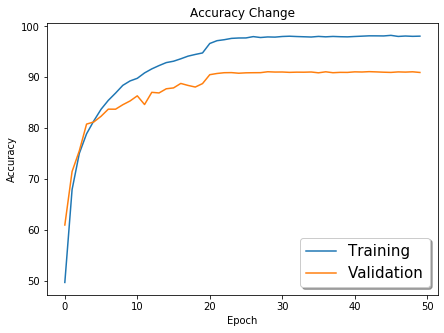

In [10]:
plot_metric(
    {'Training': train_accuracies, 'Validation': val_accuracies}, 'Accuracy'
)

### GradCAM

Let's display GradCAM of any 25 misclassified images

In [11]:
layers = ['layer4']
grad_cam = GradCAMView(
    model, layers,
    device, dataset.mean, dataset.std
)

gradcam_views = grad_cam([x['image'] for x in incorrect_samples])

Mode set to GradCAM.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [0]:
def plot_gradcam(cam_data, pred_data, classes, plot_name):
    # Initialize plot
    fig, axs = plt.subplots(len(cam_data), 2, figsize=(4, 60))

    for idx in range(len(cam_data)):
        label = classes[pred_data[idx]['label']]
        prediction = classes[pred_data[idx]['prediction']]

        axs[idx][0].axis('off')
        axs[idx][0].set_title(f'Image: {idx + 1}\nLabel: {label}')
        axs[idx][0].imshow(cam_data[idx]['image'])

        axs[idx][1].axis('off')
        axs[idx][1].set_title(f'GradCAM: {idx + 1}\nPrediction: {prediction}')
        axs[idx][1].imshow(cam_data[idx]['result']['layer4'])
    
    # Set spacing
    fig.tight_layout()
    fig.subplots_adjust(top=1.1)

    # Save image
    fig.savefig(plot_name, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


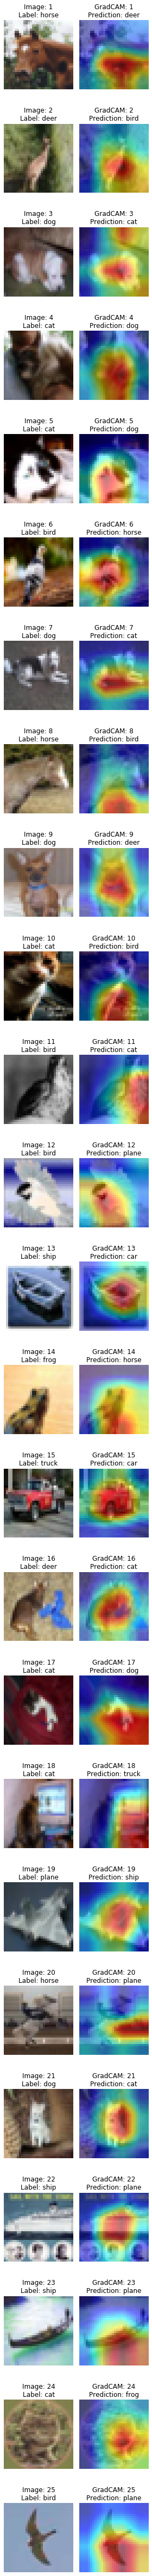

In [13]:
plot_gradcam(gradcam_views, incorrect_samples, dataset.classes, 'pred_gradcam.png')

## Result Analysis

Displaying accuracy for each class in the entire validation dataset

In [14]:
class_level_accuracy(model, val_loader, device, dataset.classes)

Accuracy of plane : 92 %
Accuracy of   car : 96 %
Accuracy of  bird : 87 %
Accuracy of   cat : 81 %
Accuracy of  deer : 90 %
Accuracy of   dog : 83 %
Accuracy of  frog : 94 %
Accuracy of horse : 93 %
Accuracy of  ship : 94 %
Accuracy of truck : 95 %
